# bertchunker: Adversarial training + optimizers

## Libraries used

In [2]:
import os, sys, argparse, gzip, re, logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import tqdm

## Documentation

The following next few cells goes through what we added and modified to achieve the improved model. 

### Augmentating the training data 

The function augment_data and add_noise is used together to add noise to the training data. The function add_noise generates different types of noise to be added to the training set. add_noise is called by augment_data . The function augment_data is reponsible for adding the new noise generated by add_noise to the training set. The variable ratio and noise_prob determines how much noise is added. This augmentation does not remove any of the old training data. 

In [1]:
def augment_data(self, ratio=0.18):
        augmented_data = []
        for sentence, tags in self.training_data:
            # Add the original data 
            augmented_data.append((sentence, tags))  
            # add amount of noise based on ratio * len sentence 
            for _ in range(int(len(sentence) * ratio)):
                noisy_sentence = self.add_noise(sentence)  # create the noise 

                # Add the noise data 
                augmented_data.append((noisy_sentence, tags))
        self.training_data = augmented_data

In [2]:
def add_noise(self, sentence, noise_prob=0.4):
        noisy_list = ['add', 'drop_char']
        noisy_sentence = []
        for word in sentence:
            noisy_word = word
       
            if torch.rand(1) < noise_prob:
                # Randomly choose a noise type 
                noise_type = noisy_list[torch.randint(0, len(noisy_list), (1,)).item()]
            
                # Add a random character to the word
                if noise_type == 'add':
                    # generate random location to insert character 
                    index = torch.randint(0, len(word), (1,))
                    # random lower case letter 
                    rdm_char = chr(ord('a') + torch.randint(0, 26, (1,)).item())
                    # add character to word 
                    noisy_word = word[:index] + rdm_char + word[index:]

                # Drop a random character from the word 
                elif noise_type == 'drop_char':
                    if len(word) > 1:
                        index = torch.randint(0, len(word), (1,)).item()
                        noisy_word = word[:index] + word[index + 1:]
                    elif len(word) == 1:
                        noisy_word = " "
                    else: 
                        noisy_word = word 

            noisy_sentence.append(noisy_word)
        return noisy_sentence

### Using two different optimizers for pre-trained encoder layers and the classification head layer
We tried combination of two Adam and Adam & SGD as optimizers. Also, we tweaked the learning rate of the optimizer for classification head layer.

In [ ]:
self.optimizers = [
            optim.Adam(
                self.encoder.parameters(),
                lr=lr
            ),
            optim.SGD(self.classification_head.parameters(), lr=5e-2)
        ]

## Analysis

### 1. Analysis of adversarial training 
We added various types of noise to the training data to test the impact of each noise type. Adding and dropping a random character randomly in a word increased the accuracy of the model. After experimenting with different characters to add like uppercase characters and symbols, we discovered adding purely lowercase characters increased the accuracy. Furthermore, we also tried replacing a word with a synonym, swapping 2 characters randomly in a word, and removing a word completely. However, these types of noise lowered the accuracy of the model so we discarded these noise type. Other variables that affected the accuracy of the model were noise_prob and ratio. After some trial and error, we found that noise_prob=0.4 and ratio=0.18 gave a relatively high score. 

Through adding noise to the training set, we were able to increase our accuracy by about 5%, but this increased the training time. The training time went up by about 5x which means this approach is not performance friendly. 

The screenshot below shows the result of only adding noise to the training set. 

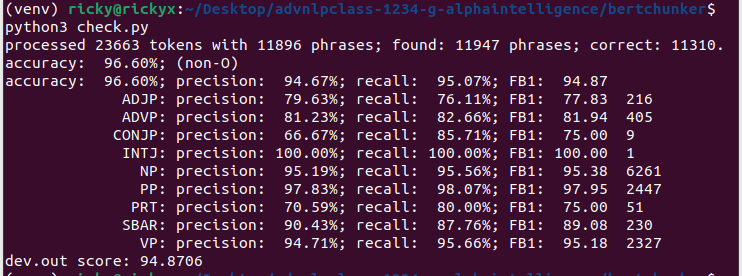

### 2. batchsize + epoch tweaks 
We tested different batchsizes and epochs. Different batchsizes had no noticeable improvement for the FB1 score, but they did affect the training speed. In addition, we tested some epoch values and discovered that epoch=1 decreased the accuracy of the model. Particularly, CONJP had a significant decrease in FB1 score. Increasing the epoch value to 3 or 4 fixed the low CONJP score and improved the accuracy of the model. Epoch values higher than 4 had no noticable impact. 

The screenshot shows the result for epoch=1 

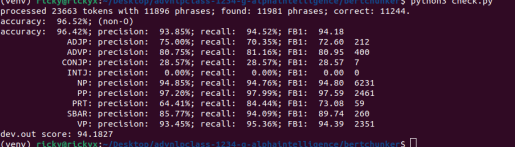

### 3. The impact of different choices of optimizers
Default solution optimizes the parameters of two layers with an Adam optimizer and learning rate of 5e-5. Using two seperated optimizers gets slightly worse results overall. When we use Adam for pre-trained encoder and SGD for classification head and set the learning rate of SGD to 5e-2, we can always get 0.1% improvement with or without adversarial training. This trial might indicate that the pre-trained encoder and the classification head layers benefit from similar optimization approaches, and using different optimizers does not bring any advantages. 

### 4. The use of multiple layers
We noticed no significant improvements or losses in the accuracy of dev after utilizing other layers in our Transformers (i.e. encoder().hidden_states in the forward function) instead of just the last layer, though further experimentation and optimization may be required before reaching a definitive conclusion, as we have not found the optimal balance of lower and upper levels as of writing. 

### 5. Combined results

With all the methods listed above combined, we were able to achieve a dev score greater than 94.5. In our limited testing, we observed the dev score fluctuated around 94.5 to 94.9. To conclude we were able to improve the accuracy of our model by about 5%. 

## Group work 

* rxa13 coded and write-up for adversarial training
* kerryz coded and write-up for different optimizers
* lwa141 coded and tested for multiple layers of pre-trained llm